<hr style="color:#a4342d;">
<p align="center">
    <b style="font-size:2.5vw; color:#a4342d; font-weight:bold;">
    Introduction to machine learning - Homework 3
    </b>
</p>
<hr style="color:#a4342d;">

<b>Authors</b>: <i>C. Bosch, M. Cornet & V. Mangeleer</i>

[comment]: <> (Section)
<hr style="color:#a4342d;">
<p align="center">
    <b style="font-size:1.5vw; color:#a4342d;">
    Initialization
    </b>
</p>
<hr style="color:#a4342d;">

[comment]: <> (Description)
<p align="justify">
    In this section, one will be able to initialize all the librairies needed. In addition to that, the untouched dataset will be loaded and inspected with an histogram made available by the incredbile Pandas librairy !

In [ ]:
# -- LIBRAIRIES --
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

# Allow notebook to plot in terminal
%matplotlib inline

In [ ]:
# -- FUNCTION --

# Used to print a basic section title in terminal
def section(title = "UNKNOWN"):

    # Number of letters to determine section size
    title_size = len(title)

    # Section title boundaries
    boundary  = "-"
    for i in range(title_size + 1):
        boundary += "-"
    
    # Printing section
    print(boundary)
    print(f" {title} ")
    print(boundary)

In [ ]:
# -- ORIGINAL DATASET --
# The original dataset is contained in the "data/original" folder

# Stores the original dataset
dataset_original_X = []
dataset_original_Y = []

# Load the original dataset
for i in range(1, 11):
    dataset_original_X.append(pd.read_csv(f"data/original/X_Zone_{i}.csv"))
    dataset_original_Y.append(pd.read_csv(f"data/original/Y_Zone_{i}.csv"))

In [258]:
# -- BASIC INFORMATION DATASET --

# Loading X and Y dataset for the first wind turbine
dataset_X1 = dataset_original_X[0]
dataset_Y1 = dataset_original_Y[0]

# Displaying their relative information
section("WIND TURBINE 1 - X Dataset")
section("HEAD")
print(dataset_X1.head())
section("INFO")
dataset_X1.info()

section("WIND TURBINE 1 - Y Dataset")
section("HEAD")
print(dataset_Y1.head())
section("INFO")
dataset_Y1.info()

----------------------------
 WIND TURBINE 1 - X Dataset 
----------------------------
------
 HEAD 
------
   ZONEID       U10       V10      U100      V100  Day  Month  Year  Hour
0       1  2.124600 -2.681966  2.864280 -3.666076    1      1  2012     1
1       1  2.521695 -1.796960  3.344859 -2.464761    1      1  2012     2
2       1  2.672210 -0.822516  3.508448 -1.214093    1      1  2012     3
3       1  2.457504 -0.143642  3.215233 -0.355546    1      1  2012     4
4       1  2.245898  0.389576  2.957678  0.332701    1      1  2012     5
------
 INFO 
------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17544 entries, 0 to 17543
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ZONEID  17544 non-null  int64  
 1   U10     17544 non-null  float64
 2   V10     17544 non-null  float64
 3   U100    17544 non-null  float64
 4   V100    17544 non-null  float64
 5   Day     17544 non-null  int64  
 6   Month   17544 non-

array([[<AxesSubplot:title={'center':'TARGETVAR'}>]], dtype=object)

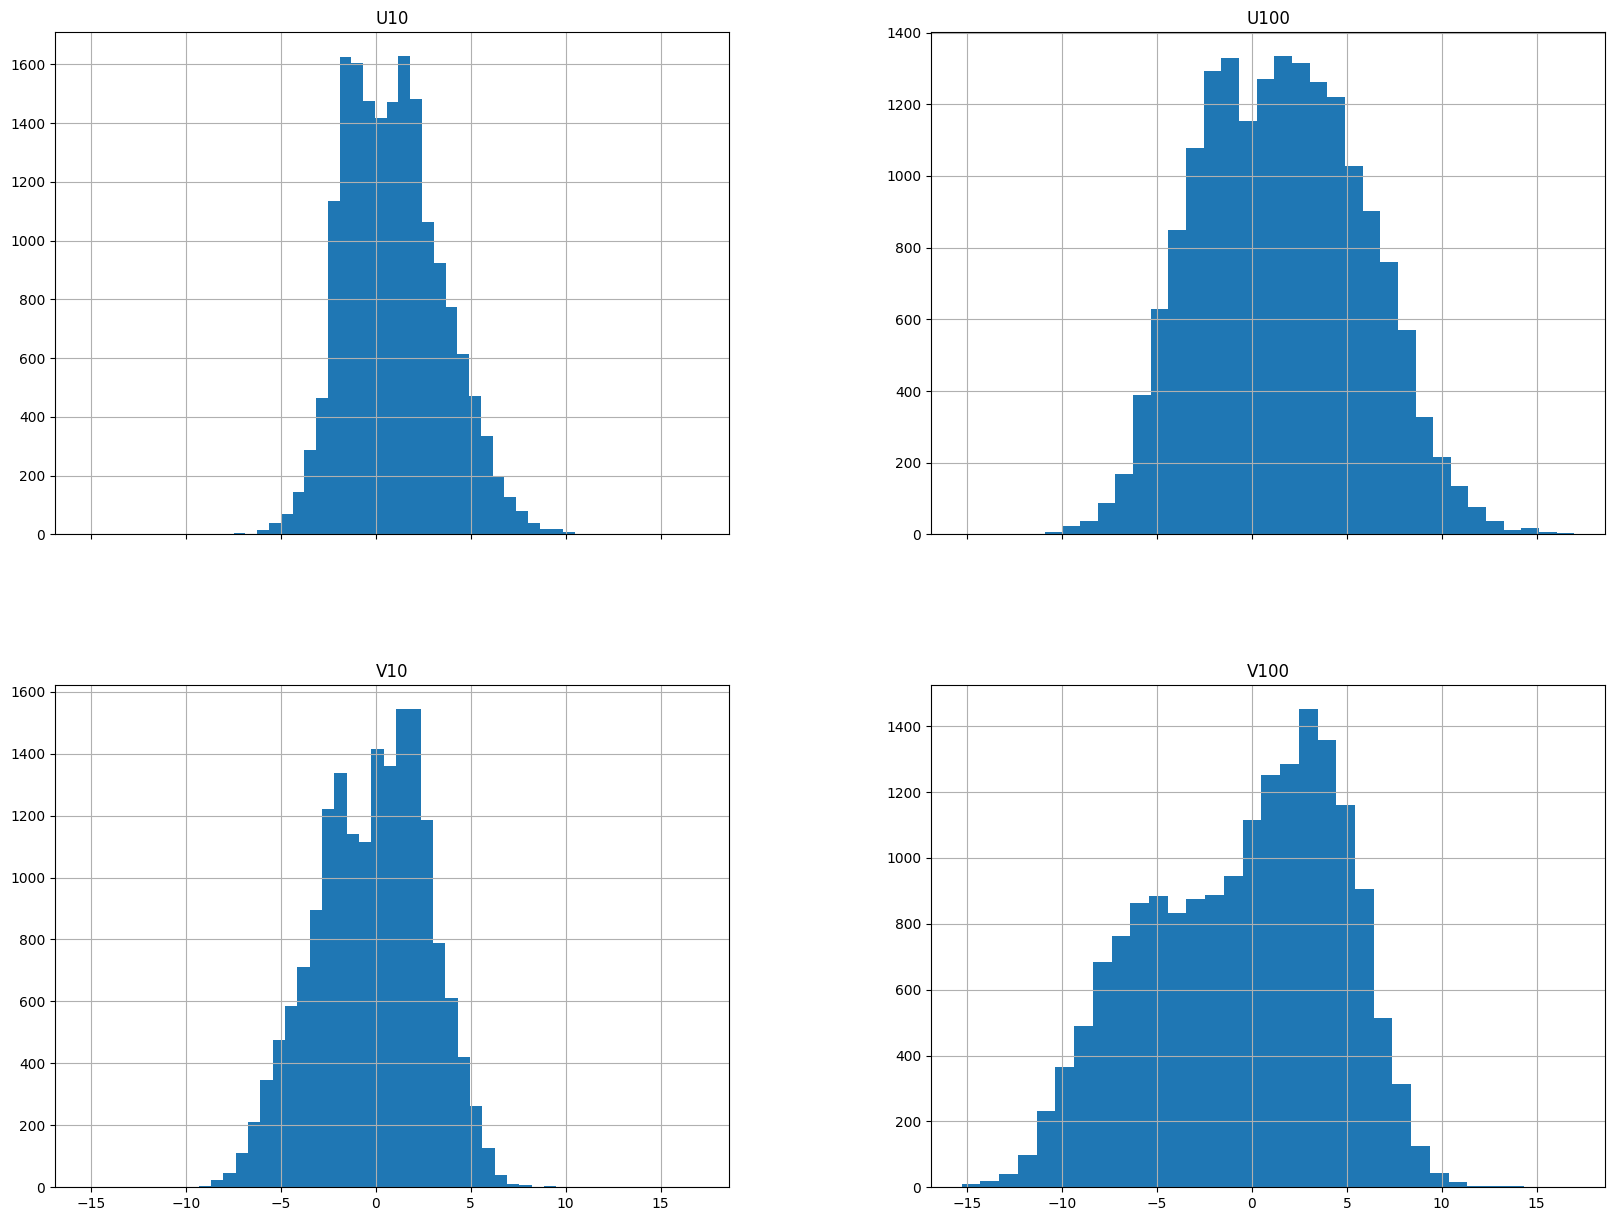

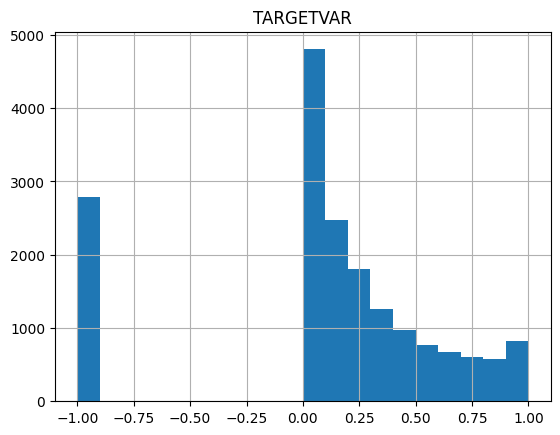

In [259]:
# -- HISTOGRAM --

# Extracting only relevant variables
dataset_X1_relevant = dataset_X1[["U10", "U100", "V10", "V100"]]
dataset_X1_relevant.hist(bins = 30, sharex = True, figsize = (20, 15))

dataset_Y1_relevant = dataset_Y1[["TARGETVAR"]]
dataset_Y1_relevant.hist(bins = 20)

# Note (I forgot):
# x-axis = speed interval in [m/s]
# y_axis = number of instances in that interval

[comment]: <> (Section)
<hr style="color:#a4342d;"></hr>
<p align="center">
    <b style="font-size:1.5vw; color:#a4342d;">
    Dataset - Train & Test | Pipeline
    </b>
</p>
<hr style="color:#a4342d;"></hr>

[comment]: <> (Description)
<p align="justify">
    In this section, one will be able to explore further the dataset ! First, one needs to create a train and test set. Then, it is interesitng to look for correlations, new variables and possible improvements to the current dataset. All the new datasets will be save in the datafolder and ready to use by our different models ! As a first intuition, I think it might be interesting to add more data in each dataset. Indeed, it could be interesting to add to each sample of the X set (one of these attributes or all of them, we must make some tests :D):
    <ul>
        <li> The mean wind speed of U and V of the current wind turbine over the past X days       (to be defined by user = TBD)</li>
        <li>The variance wind speed of U and V of the current wind turbine over the past X days   (TBD)</li>
        <li>The zonal average speed average over all wind turbine of U and V over the past X days (TBD)</li>
        <li>The values of U and V of the past Y slices                                            (TBD)</li>
    </ul>
    I don't think having all of these features at the same time is usefull, we should try many combinations !
</p>

In [ ]:
# -- MEAN, VARIANCE, ZONAL AVERAGE SPEED AND TIME STEPS --
#
#------------
# Parameters
#------------
# Number of days to compute mean value
nb_days_mean   = 10

# Number of time slices of former sample to add
nb_time_slices = 2

#-----------
# Functions
#-----------
# Used to compute the mean and variance of a variable over some timeslices in the dataset
def computeMeanVariance(datasets, 
                        variables = ["U100"     , "V100"],
                        names_m   = ["U100_mean", "V100_mean"],
                        names_v   = ["U100_var" , "V100_var"],
                        window    = 100):

    # Security
    assert len(variables) == len(names_m), "Each variable should have a name for its mean"
    assert len(variables) == len(names_v), "Each variable should have a name for its var"
    assert window > 1, "Window size must be greater than 1 to compute mean and var"

    # Looping over all the datasets
    for d in datasets:

        # Looping over the variables whose mean and var must be computed
        for v, nm, nv in zip(variables, names_m, names_v):

            # Retreiving data 
            data = d.loc[: , [v]].to_numpy()

            # Stores mean and variance (1st and 2nd : mean = their value, var = 0 otherwise NAN problem while computation)
            mean = [data[0][0], data[1][0]]
            var  = [0, 0]

            for i in range(2, len(data)):

                # Start and end index for computation
                index_start = i - window if i - window >= 0 else 0
                index_end   = i - 1 if i - 1 >= 0 else 0

                # Computing mean and variance (much faster using numpy variables)
                mean.append(np.mean(data[index_start:index_end]))
                var.append(np.var(data[index_start:index_end]))
            
            # Adding new data to dataset
            d[nm] = mean
            d[nv] = var

# Used to compute the instantenous mean and variance of a variable accross multiple datasets
def computeZonalValue(datasets, 
                      variables = ["U100"           , "V100"],
                      names_m   = ["U100_zonal_mean", "V100_zonal_mean"],
                      names_v   = ["U100_zonal_var" , "V100_zonal_var"]):

    # Security
    assert len(variables) == len(names_m), "Each variable should have a name for its zonal mean"
    assert len(variables) == len(names_v), "Each variable should have a name for its zonal var"
    assert len(datasets) > 1, "To compute mean and var, at least 2 datasets are needed"

    # Looping over the variables whose mean and var must be computed
    for v, nm, nv in zip(variables, names_m, names_v):

        # Number of samples
        nb_samples = len(datasets[0])

        # Stores all the different values in numpy matrix for efficient computation
        data = np.zeros((nb_samples, len(datasets)))

        # Retreiving all the corresponding data
        for i, d in enumerate(datasets):
            
            # Squeeze is there to remove useless dimension (Ask Victor)
            data[:, i] = np.squeeze(d.loc[: , [v]].to_numpy())

        # Computing mean and variance (much faster using numpy variables)
        mean = np.mean(data, axis = 1) # Axis = 1 to make mean over each row
        var  = np.var(data, axis = 1)

        # Adding new data to all the datasets
        for d in datasets:
            d[nm] = mean
            d[nv] = var

# Used to normalize the data of different variables
def normalize(datasets,
              variables = ["U100", "V100"]):

    # Looping over all the datasets
    for d in datasets:

        # Looping over the different columns
        for i, c in enumerate(d.columns):

            # Check if the column must be normalized
            if c in variables:
                
                # Retreiving data
                data = d.iloc[:, i].to_numpy()

                # Normalizing the column
                d.iloc[:, i] = (data - np.mean(data))/np.std(data)
              

In [ ]:
# -- DATA LOADER -- 
# This class has for purpose to handle the data and make our life easier ! You will be able to:
# - Store the original dataset (a list of .csv for X and another for Y)
# - Define and apply a pipeline on the data and store a copy of it (leaving original data untouched)
# - Combine all the small datasets into a big one
# - Split the data into a train and test set
# - Save your new dataset
# - Load a dataset

import copy
from sklearn.model_selection import train_test_split

class dataLoader():
    
    # Initialization of the loader
    def __init__(self, datasets_X, datasets_Y):

        # Stores the original, transformed and final datasets
        self.original_datasets_X    = datasets_X
        self.original_datasets_Y    = datasets_Y
        self.transformed_datasets_X = datasets_X
        self.transformed_datasets_Y = datasets_Y
        self.final_dataset_X        = None
        self.final_dataset_Y        = None

    # Used to display the head of the transformed dataset (first set)
    def showHeadTransformed(self):
        section("Dataset - X - Transformed")
        print(self.transformed_datasets_X[0].head())
        section("Dataset - Y - Transformed")
        print(self.transformed_datasets_Y[0].head())

    # Used to display the head of the final dataset (first set)
    def showHeadFinal(self):
        section("Dataset - X - Final")
        print(self.final_dataset_X.head())
        section("Dataset - Y - Final")
        print(self.final_dataset_Y.head())

    # Used to split the final dataset into a trial and test set
    def splitTrainTest(self, test_size = 0.3):

        # Computing train and test sets
        return train_test_split(self.final_dataset_X, self.final_dataset_Y, test_size = test_size)

    # Used to combine all the transformed datasets into a big one
    def combine(self):
        self.final_dataset_X = pd.concat(self.transformed_datasets_X)
        self.final_dataset_Y = pd.concat(self.transformed_datasets_Y)

    # Used to save the final dataset in .csv format for later
    def save(self, name = "dataset_1"):
        self.final_dataset_X.to_csv(f"data/{name}_X.csv")
        self.final_dataset_X.to_csv(f"data/{name}_Y.csv")

    #--------------------------------------------------------------------------------
    #                                    PIPELINES
    #--------------------------------------------------------------------------------
    #
    # TYPE 1 - Normalization, Average and Var, Zonal of U100 and V100
    def pipeline_1(self, window   = 10,
                         var      = ["U100", "V100"],
                         n_aver   = ["U100_mean", "V100_mean"],
                         n_var    = ["U100_var" , "V100_var"],
                         n_z_aver = ["U100_zonal_mean", "V100_zonal_mean"],
                         n_z_var  = ["U100_zonal_var" , "V100_zonal_var"]):

        # Copying original dataset
        dX = copy.deepcopy(self.original_datasets_X)
        dY = copy.deepcopy(self.original_datasets_Y)

        # Applying transformations
        normalize(dX, variables = var)
        normalize(dY, variables = ["TARGETVAR"])
        computeMeanVariance(dX, variables = var, names_m = n_aver,   names_v = n_var, window = window)
        computeZonalValue(  dX, variables = var, names_m = n_z_aver, names_v = n_z_var)

        # Updating dataset
        self.transformed_datasets_X = dX
        self.transformed_datasets_Y = dY


In [ ]:
# -- DATA LOADER - ILLUSTRATION -- 
#
# Initialization of the loader
loader = dataLoader(dataset_original_X, dataset_original_Y)

# Aplying the first prototype of pipeline (Mean value on 30 days)
loader.pipeline_1(window = 24 * 7)

# Check the new shape of the datasets
loader.showHeadTransformed()

# Combine all the small datasets into a big one
loader.combine()

# Retreives the train and test set (in Pandas frame)
train_X, test_X, train_Y, test_Y = loader.splitTrainTest()

# Saving the new dataset
loader.save(name = "Dataset_1")

In [250]:
# -- FIRST MODEL TESTING BUT IT'S LATE I HAVE NO HOPE

# Copying df for test
dX_train = copy.deepcopy(train_X)
dY_train = copy.deepcopy(train_Y)
dX_test  = copy.deepcopy(test_X)
dY_test  = copy.deepcopy(test_Y)

# Conversion to numpy
dX_train_np = dX_train.to_numpy()
dY_train_np = dY_train.to_numpy()
dX_test_np  = dX_test.to_numpy()
dY_test_np  = dY_test.to_numpy()

In [257]:
from sklearn.neighbors import KNeighborsRegressor

# Initialization of the model
model = KNeighborsRegressor(n_neighbors = 10)

# Training on the train set
model.fit(dX_train_np, dY_train_np)

# Computing accuracy
accuracy = model.score(dX_test_np, dY_test_np)

print(f"Accuracy = {accuracy}")

Accuracy = 0.9197044317224545


In [261]:
from sklearn.tree import DecisionTreeRegressor

model = DecisionTreeRegressor(max_depth = 20)

# Training on the train set
model.fit(dX_train_np, dY_train_np)

# Computing accuracy
accuracy = model.score(dX_test_np, dY_test_np)

print(f"Accuracy = {accuracy}")

Accuracy = 0.8324393908108055
